In [1]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms.v2 import RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, Dataset, DataLoader
import matplotlib.pyplot as plt

from src.data_utils import TransformDataset

# Этап 1. Загрузка и предобработка данных

acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
acc_long_600_mg
advil_ultra_forte
advil_ultra_forte
advil_ultra_forte
advil_ultra_forte
advil_ultra_forte
Количество изображений в train: 2352
Количество изображений в val: 504
Список классов ['acc_long_600_mg', 'advil_ultra_forte', 'akineton_2_mg', 'algoflex_forte_dolo_400_mg', 'algoflex_rapid_400_mg', 'algopyrin_500_mg', 'ambroxol_egis_30_mg', 'apranax_550_mg', 'aspirin_ultra_500_mg', 'atoris_20_mg', 'atorvastatin_teva_20_mg', 'betaloc_50_mg', 'bila_git', 'c_vitamin_teva_500_mg', 'calci_kid', 'cataflam_50_mg', 'cataflam_dolo_25_mg', 'cetirizin_10_mg', 'cold_fx', 'coldrex', 'concor_10_mg', 'concor_5_mg', 'condrosulf_800_mg', 'controloc_20_mg', 'covercard_plus_10_mg_2_5_mg_5_mg', 'coverex_4_mg', 'diclopram_75-mg_20-mg', 'dorithricin_mentol', 'dulsevia_60_mg', 'enter

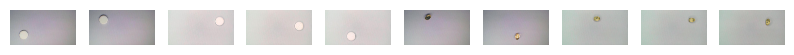

In [3]:
train_transforms = Compose([
    RandomHorizontalFlip(p=0.2),
    RandomVerticalFlip(p=0.2),
    RandomRotation([-5, 5], fill=255.),
    Resize((224, 224)),
    ToTensor(),
    Normalize((0.5), (0.5))
])

test_transforms = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize((0.5), (0.5))
])

train_data = ImageFolder('./data/train')
val_data = ImageFolder('./data/test')

fig = plt.figure(figsize=(10,5))
for index in range (1, 11):
    image, label = train_data[index]
    print(train_data.classes[label])
    plt.subplot(1, 10, index)
    plt.imshow(image)
    plt.axis('off')

for index in range (1, 11):
    image, label = val_data[index]
    print(val_data.classes[label])
    plt.subplot(1, 10, index)
    plt.imshow(image)
    plt.axis('off')

train_dataset = TransformDataset(train_data, train_transforms)
val_dataset = TransformDataset(val_data, test_transforms)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("Количество изображений в train:", len(train_dataset))
print("Количество изображений в val:", len(val_dataset))
print("Список классов", train_data.classes)
print("Количество классов", len(train_data.classes))

# Этап 2. Объявление модели

In [ ]:
from torchsummary import summary
from torchvision.models import mobilenet_v3_small
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model = mobilenet_v3_small(weights='IMAGENET1K_V1')
model.classifier = nn.Linear(in_features=576, out_features=84, bias=True)
model.to(device)
print(device)
for param in model.parameters():
    param.requires_grad = False


for param in model.classifier.parameters():
    param.requires_grad = True

summary(model, input_size=(3, 224, 224)) 

# Этап 3. Дообучение

In [ ]:
from torchvision.models import mobilenet_v3_small
import torch.nn as nn
import torch.optim as optim
import torch
from tqdm.auto import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 3
best_vloss = 1e5

def train_one_epoch(epoch_index):
    running_loss = 0.0
    epoch_loss = 0.0 
    num_batches = 0
    
    train_bar = tqdm(
        train_loader,
        desc=f"Тренировка (эпоха {epoch_index + 1})",
    )

    for batch_index, (inputs, labels) in enumerate(train_bar):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value
        epoch_loss += loss_value
        num_batches += 1

        if (batch_index + 1) % 20 == 0:
            running_loss = 0.0

    avg_loss = epoch_loss / num_batches
    return avg_loss


for epoch in range(EPOCHS):
    model.train(True)
    avg_loss = train_one_epoch(epoch)

    model.eval()
    running_vloss = 0.0
    val_bar = tqdm(
        val_loader,
        desc=f"Валидация (эпоха {epoch + 1})",
    )
    with torch.no_grad():
        for i, vdata in enumerate(val_bar):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'tablets_classifier_{epoch}.pt'
        torch.save(model.state_dict(), model_path)

    print(f'Ошибка train {avg_loss}, ошибка val {avg_vloss}') 

# Этап 4. Оценка качества

In [ ]:
from sklearn.metrics import classification_report
labels_predicted = []
labels_true = []

model.eval()

with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        labels_predicted.extend(predicted.detach().cpu().numpy())
        labels_true.extend(labels.detach().cpu().numpy())

print(classification_report(labels_true, labels_predicted, target_names=dataset.classes))